# Sentiment Analysis with TensorFlow

In [10]:
import tensorflow as tf
import re
import string

# Data Loading

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [3]:
dataset = tf.keras.utils.get_file(
    "aclImdb_v1",
    url,
    extract=True,
    cache_dir="."
)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 120s 1us/step


# Understanding the Dataset

In [4]:
import os
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, "pos/0_9.txt") # Positive review sample. 
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


# Data Preprocessing

In [7]:
import shutil # For removing the unsupervised data. Shutil is a utility module in Python that comes with many operations on files and collections of files.
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [8]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory( # This function creates a tf.data.Dataset from text files in a directory. Folders must be named as classes to be able to use this function. For example, if we have a folder named "pos" and another folder named "neg", we can use this function to create a dataset from these folders.
    "datasets/aclImdb/train",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1): # The take method takes the first 1 group from the dataset. The group size is 32 because we defined the batch size as 32.
  for i in range(3):
    print("Review:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Text: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Text: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into c

In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory( # We created validation dataset
    "datasets/aclImdb/train",
    batch_size=32,
    validation_split=0.2,
    subset="validation", # The subset parameter is used to specify whether the dataset is for training or validation.
    seed=42, 
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory( # Test dataset
    "datasets/aclImdb/test",
    batch_size=32,
)

Found 25000 files belonging to 2 classes.


In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", "") # We removed the "<br />" tags from the text.
  return tf.strings.regex_replace(
      stripped_html, f"[{re.escape(string.punctuation)}]", "") # We removed the punctuations from the text.

In [13]:
vectorize_layer = tf.keras.layers.TextVectorization( # We created a TextVectorization layer. This layer will be used to vectorize the text data. The vectorize_layer will convert the text data to numerical data.
    standardize=custom_standardization,
    max_tokens=10000, # We defined the maximum number of tokens as 10000. Why? Because we want to use the 10000 most frequent words in the dataset.
    output_sequence_length=250 # We defined the output sequence length as 250. Sentence length is important in NLP tasks. We need to define a fixed length for the sentences. We can use padding for the sentences that are shorter than the defined length.
)

In [14]:
train_text = raw_train_ds.map(lambda x, y: x) # We created a dataset that contains only the text data. Because label data is also integer. (0: negative, 1: positive)

In [15]:
vectorize_layer.adapt(train_text) # We adapted the vectorize_layer to the text data.

In [16]:
def vectorize_text(text, label): # We defined a function to vectorize the text data.
  text = tf.expand_dims(text, -1) # We expanded the dimensions of the text data. Why? Because the vectorize_layer expects a 2D input. We added a new dimension to the text data.
  return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds)) # We took the first group from the raw_train_ds dataset.
first_review, first_label = text_batch[0], label_batch[0] # We took the first data and its label.
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Processed data: ", vectorize_text(first_review, first_label)) # We vectorized the first data.

Review:  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label:  neg
Processed data:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  257,    2,  222,    1,  574,   30,  227,   10, 2401,
           1,   52,   23,   25,  426,  248,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [18]:
print("345 --->", vectorize_layer.get_vocabulary()[345]) # We printed the word corresponding to the index 345.
print("999 --->", vectorize_layer.get_vocabulary()[999])

345 ---> wrong
999 ---> pay


In [19]:
train_ds = raw_train_ds.map(vectorize_text) # We vectorized the raw_train_ds dataset. So, we converted the text data to numerical data.
val_ds = raw_val_ds.map(vectorize_text) # We vectorized the raw_val_ds dataset. 
test_ds = raw_test_ds.map(vectorize_text)

# Configuring the dataset for performance

For the best performance, we need to configure the dataset. We can use the cache and prefetch methods to improve the performance of the dataset.

- cache: This method caches the data in memory. So, the data will be loaded from the memory instead of the disk. This will improve the performance of the dataset.
- prefetch: This method overlaps the preprocessing and model execution of the data. So, while the model is executing training step s, the input pipeline is reading the data for the step s+1. This will improve the performance of the dataset.

In [20]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) # We cached and prefetched the train_ds dataset. AUTOTUNE is a special value that will delegate the decision about what level of parallelism to use to the tf.data runtime.
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Embedding is a way to change words or sequences into numbers. It helps to understand the meaning of words better.

### 1. Comparison with One-Hot Encoding:
Let’s say we have these three words:
- "cat"
- "dog"
- "bird"

With one-hot encoding, the words look like this:
- "cat" = `[1, 0, 0]`
- "dog" = `[0, 1, 0]`
- "bird" = `[0, 0, 1]`

Each word is only 1 in one place, and 0 in the others. But this does not show any connection between the words. For example, "cat" and "dog" are similar, but their vectors are very different.

### 2. Embedding Representation:
Using the **Embedding Layer**, the words can be represented by vectors like these (in 2 dimensions):
- "cat" = `[0.25, 0.80]`
- "dog" = `[0.20, 0.85]`
- "bird" = `[0.90, 0.10]`

Here, "cat" and "dog" have similar vectors because they are similar words. "bird" is further away because it is not as similar.

### 3. Semantic Similarity:
Embedding helps to show the relationship between words. For example, if we have more words:
- "cat" = `[0.25, 0.80, 0.50]`
- "dog" = `[0.24, 0.78, 0.48]`
- "bird" = `[0.80, 0.10, 0.20]`
- "car" = `[0.10, 0.05, 0.95]`

Now, "cat" and "dog" are close to each other because they are similar. "bird" is a bit further, but "car" is much further because it’s very different.

### 4. Example with a Model:
Here is an example in TensorFlow to show how embedding works:

```python
import tensorflow as tf

# Number of unique words (for example, 10,000 words)
vocab_size = 10000  
# Size of the embedding vectors
embedding_dim = 16  

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1)
])

# Model summary
model.summary()
```

In this model:

input_dim=vocab_size+1: This shows the number of unique words (for example, 10,000 words).
output_dim=16: This means each word will have a vector with 16 numbers.

### 5. Real-World Example:
If we train a model with a lot of texts, it will learn that "cat" and "dog" are similar and place them close in the embedding space. For example:

-"cat": [0.5, 0.1]
-"dog": [0.49, 0.12]
But if the word "plane" is not often used with "cat" and "dog", it will be further away:

-"plane": [0.8, 0.9]
These representations help the model to understand the relationship between words.

Summary:
The Embedding layer is used to represent words or sequences in a meaningful way with numbers. This helps the model understand relationships between words and perform better in tasks like text analysis or classification.


In [21]:
max_features=10000 # We defined the maximum number of features as 10000. We will use the 10000 most frequent words in the dataset.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, 16), # We created an Embedding layer. The input dimension is max_features+1 and the output dimension is 16.
    tf.keras.layers.Dropout(0.2), # We added a Dropout layer. Dropout is a regularization technique that helps to prevent overfitting.
    tf.keras.layers.GlobalAveragePooling1D(), # We added a GlobalAveragePooling1D layer. This layer will average the embeddings of all words in the sentence.
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1), # We added a Dense layer. The output of this layer will be the prediction. Binary classification is a type of classification where the target variable has two possible values.
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [22]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), # We defined the loss function as BinaryCrossentropy. This loss function is used for binary classification tasks.
    optimizer = "adam",
    metrics = tf.metrics.BinaryAccuracy(threshold=0.0) # We defined the metric as BinaryAccuracy.
)

# Model Training

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 72s 107ms/step - loss: 0.6656 - binary_accuracy: 0.6865 - val_loss: 0.6171 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5512 - binary_accuracy: 0.7988 - val_loss: 0.5015 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4487 - binary_accuracy: 0.8427 - val_loss: 0.4244 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3829 - binary_accuracy: 0.8631 - val_loss: 0.3782 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3408 - binary_accuracy: 0.8768 - val_loss: 0.3497 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3098 - binary_accuracy: 0.8879 - val_loss: 0.3305 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 4s 6ms/

# Model Testing

In [24]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3154 - binary_accuracy: 0.8701
Loss:  0.3153642416000366
Accuracy:  0.8701199889183044


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

# Data Visualization

In [26]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

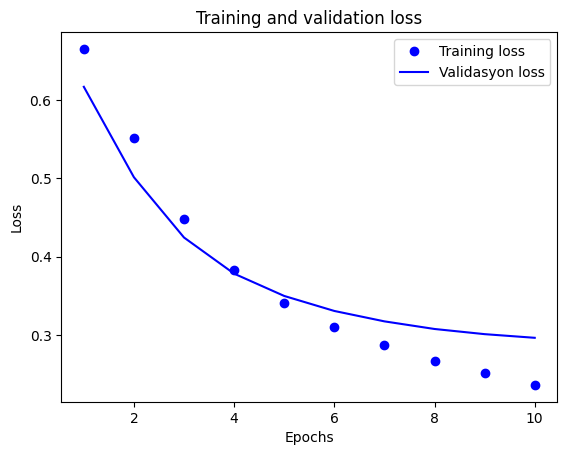

In [27]:
import matplotlib.pyplot as plt
epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Above graph shows the training and validation loss. The training loss decreases as the number of epochs increases. However, the validation loss starts to increase after a certain number of epochs. This is a sign of overfitting. 

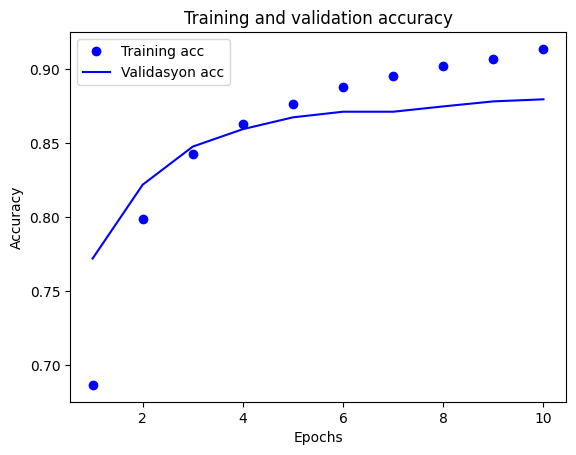

In [28]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Model Export

In [29]:
export_model = tf.keras.Sequential([ # We created a new model for exporting. This model will be used for inferencing.
    vectorize_layer,
    model,
    tf.keras.layers.Activation("sigmoid")
])

In [30]:
export_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer="adam",
    metrics = ["accuracy"]
)

In [31]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 5s 6ms/step - loss: 0.3154 - accuracy: 0.8701
0.8701199889183044


# Inferencing on new data

In [32]:
examples = [
  "The movie was awesome!",
  "The movie was nice.",
  "The movie was awful..."
]

In [33]:
export_model.predict(examples)

1/1 [==============================] - 0s 141ms/step


array([[0.5716059 ],
       [0.53324556],
       [0.3169158 ]], dtype=float32)

# Conclusion 
if the model is not good enough, we can try different hyperparameters, different architectures, or different preprocessing techniques. We can also use more data to improve the model.
array([[0.5716059 ],
       [0.53324556],
       [0.3169158 ]], dtype=float32) 
The model predicts the sentiment of the examples. The first example is positive, the second example is positive, and the third example is negative.